In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [4]:
%cd /content/drive/My\ Drive/AutoEncoders/

/content/drive/My Drive/AutoEncoders


In [0]:
import os
from matplotlib import pyplot as plt
from math import floor
import seaborn as sns
import pandas as pd
import numpy as np
import random
from scipy import ndarray      # n-dimensional Array
import skimage as sk           # used for image Processing
from skimage import transform
from skimage import util
import warnings
import keras
warnings.filterwarnings('ignore')  # remove the warnings
from keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
from keras.regularizers import l2 # for model
from keras.layers import Input,Conv2D,Dense, Dropout, BatchNormalization, MaxPooling2D, Activation, Flatten, AvgPool2D,InputLayer,GlobalAveragePooling2D,UpSampling2D
from keras.layers import  BatchNormalization as btn
from keras.models import Model, Sequential
from keras.datasets import mnist
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import VGG16
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score
from keras.callbacks import LearningRateScheduler   
from IPython.display import HTML
import base64
from keras.optimizers import RMSprop
from scipy.ndimage.interpolation import shift
from keras.optimizers import Adam
from keras.datasets import cifar10
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from keras.preprocessing.image import img_to_array, load_img
from sklearn.model_selection import train_test_split
import cv2 as cv
import math

%matplotlib inline

In [0]:
(X_train,y_train),(X_test,y_test) = mnist.load_data()

In [0]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=0, test_size=0.1)

In [8]:
print("Shape of X_train:  ",X_train.shape)
print("Shape of y_train:  ",y_train.shape)
print("="*40)
print("Shape of X_val:  ",X_val.shape)
print("Shape of y_val:  ",y_val.shape)
print("="*40)
print("Shape of X_test:  ",X_test.shape)
print("Shape of y_test:  ",y_test.shape)

Shape of X_train:   (54000, 28, 28)
Shape of y_train:   (54000,)
Shape of X_val:   (6000, 28, 28)
Shape of y_val:   (6000,)
Shape of X_test:   (10000, 28, 28)
Shape of y_test:   (10000,)


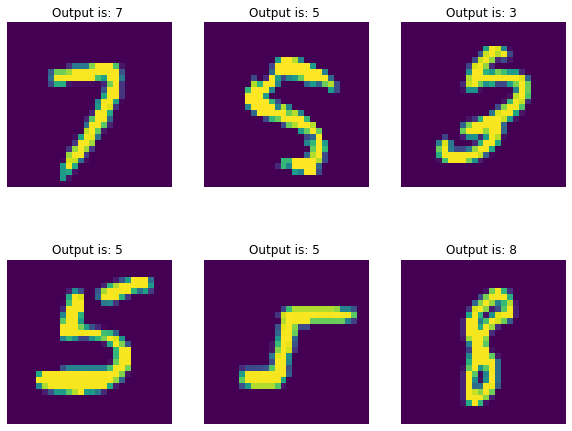

In [9]:
# visulaization of Denoised Image
plt.figure(figsize=(10,8))
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.imshow(X_train[i])
  plt.title(f"Output is: {y_train[i]} ")
  plt.axis('off')

In [33]:
X_train = X_train.astype('float32')/255.0
X_val = X_val.astype('float32')/255.0
X_test = X_test.astype('float32')/255.0


X_train = np.reshape(X_train,newshape=(len(X_train),28,28,1))
X_val = np.reshape(X_val,newshape=(len(X_val),28,28,1))
X_test = np.reshape(X_test,newshape=(len(X_test),28,28,1))

# addition of noise to the image. 0.4 is our noise factor that determines how much we have to add the noise

X_train_noisy = X_train + 0.4 * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape)
X_val_noisy = X_val + 0.4 * np.random.normal(loc=0.0, scale=1.0, size=X_val.shape)
X_test_noisy = X_test + 0.4 * np.random.normal(loc=0.0, scale=1.0, size=X_test.shape)

print(f'Shape of X_train_noisy:  ',X_train_noisy.shape)
print(f'Shape of X_val_noisy:  ',X_val_noisy.shape)
print(f'Shape of X_test_noisy: ',X_test_noisy.shape)

Shape of X_train_noisy:   (54000, 28, 28, 1)
Shape of X_val_noisy:   (6000, 28, 28, 1)
Shape of X_test_noisy:  (10000, 28, 28, 1)


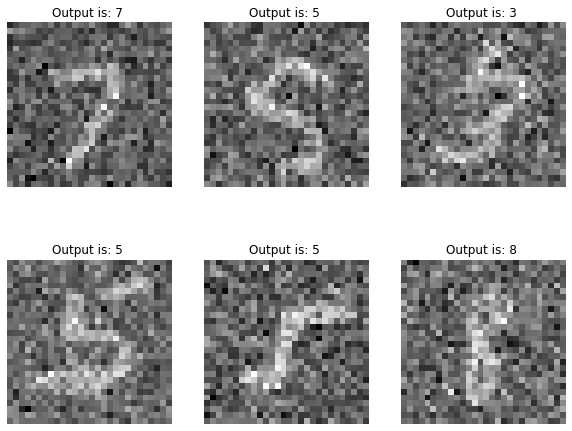

In [34]:
# visulaization of Noisy Image
plt.figure(figsize=(10,8))
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.imshow(X_train_noisy[i].reshape((28,28)),cmap='gray')
  plt.title(f"Output is: {y_train[i]} ")
  plt.axis('off')

In [0]:
#designing of Encoder 

input_image = Input(shape=(28,28,1))

encoder = Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same')(input_image)                  
encoder = MaxPooling2D(pool_size=(2,2))(encoder)

encoder = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same')(encoder)
encoder = MaxPooling2D(pool_size=(2,2))(encoder)

# encoder = Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu')(encoder)
# encoder = MaxPooling2D(pool_size=(2,2))(encoder)

encoder = Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu')(encoder)

In [0]:
# designing of Decoder

# decoder = Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu')(encoder)
# decoder = UpSampling2D((2,2))(decoder)

decoder = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same')(encoder)
decoder = UpSampling2D((2,2))(decoder)

decoder = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same')(decoder)
decoder = UpSampling2D((2,2))(decoder)

output = Conv2D(filters=1, kernel_size=(3,3), strides=(1,1), activation='sigmoid', padding='same')(decoder)

In [0]:
model_denoisy = Model(input_image,output)

In [56]:
model_denoisy.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 7, 7, 128)         73856     
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 7, 7, 128)         1475

In [0]:
model_denoisy.compile(optimizer='RMSprop', metrics=['accuracy'], loss='binary_crossentropy')

In [58]:
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.94 ** x)
history = model_denoisy.fit(X_train_noisy, X_train, batch_size=64,epochs=32,validation_data=(X_val,X_val),callbacks=[annealer])

Train on 54000 samples, validate on 6000 samples
Epoch 1/32
54000/54000 [==============================] - 6s 107us/step - loss: 0.1151 - accuracy: 0.8109 - val_loss: 0.0830 - val_accuracy: 0.8145
Epoch 2/32
54000/54000 [==============================] - 6s 104us/step - loss: 0.0890 - accuracy: 0.8142 - val_loss: 0.0790 - val_accuracy: 0.8150
Epoch 3/32
54000/54000 [==============================] - 6s 104us/step - loss: 0.0860 - accuracy: 0.8145 - val_loss: 0.0813 - val_accuracy: 0.8148
Epoch 4/32
54000/54000 [==============================] - 6s 104us/step - loss: 0.0844 - accuracy: 0.8146 - val_loss: 0.0794 - val_accuracy: 0.8149
Epoch 5/32
54000/54000 [==============================] - 6s 103us/step - loss: 0.0834 - accuracy: 0.8147 - val_loss: 0.0765 - val_accuracy: 0.8150
Epoch 6/32
54000/54000 [==============================] - 6s 103us/step - loss: 0.0827 - accuracy: 0.8148 - val_loss: 0.0732 - val_accuracy: 0.8152
Epoch 7/32
54000/54000 [==============================] - 6s 10

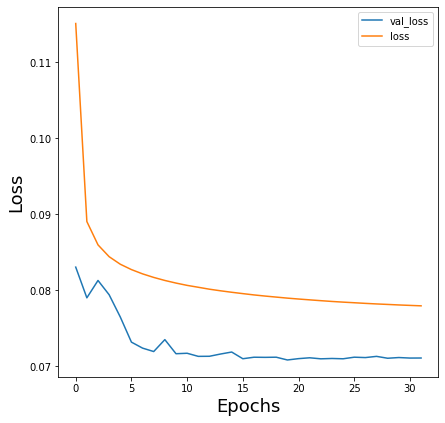

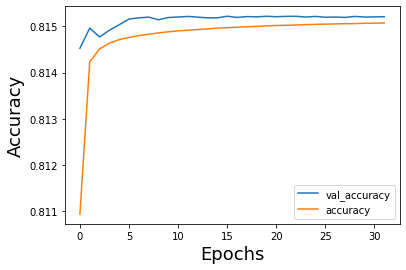

In [59]:
name_title = ['Loss','Accuracy']
# for net in range(nets):
fig=plt.figure(figsize=(64,64))
for i in range(0,2):
    ax=fig.add_subplot(8,8,i+1)
    plt.plot(history.history[list(history.history.keys())[i]], label = list(history.history.keys())[i] )
    plt.plot(history.history[list(history.history.keys())[i+2]],label = list(history.history.keys())[i+2] )
    plt.xlabel('Epochs', fontsize=18)
    plt.ylabel(name_title[i], fontsize=18)
    plt.legend()
    plt.show()

In [0]:
X_test_predict = model_denoisy.predict(X_test)

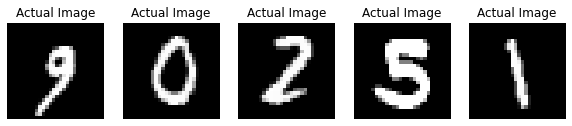

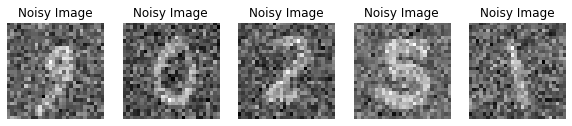

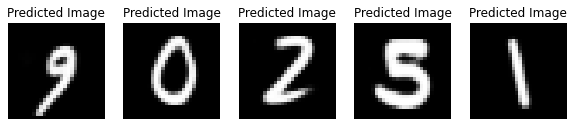

In [65]:
plt.figure(num=1,figsize=(10,8))
for i in range(1000,1005):
  plt.subplot(1,5,i+1-1000)
  plt.imshow(X_test[i].reshape((28,28)),cmap='gray')
  plt.title("Actual Image")
  plt.axis('off')

plt.figure(num=2,figsize=(10,8))
for j in range(1000,1005):
  plt.subplot(1,5,j+1-1000)
  plt.imshow(X_test_noisy[j].reshape((28,28)),cmap='gray')
  plt.title("Noisy Image")
  plt.axis('off')


plt.figure(num=3,figsize=(10,8))
for j in range(1000,1005):
  plt.subplot(1,5,j+1-1000)
  plt.imshow(X_test_predict[j].reshape((28,28)),cmap='gray')
  plt.title("Predicted Image")
  plt.axis('off')

In [66]:
X_test_tsne = np.reshape(X_test_predict,newshape=(len(X_test_predict),784))
print(X_test_tsne.shape)

(10000, 784)


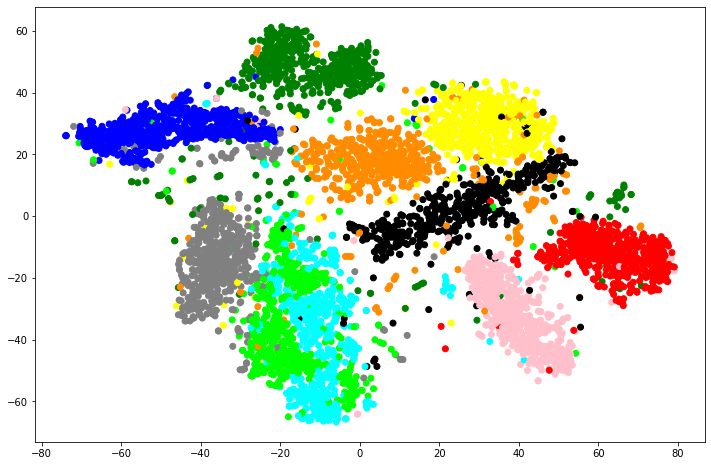

In [68]:
# Dimensionality reduction Visualization
plt.figure(figsize=(12,8))
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2,perplexity=70,learning_rate=200.0,n_iter=5000)
X_embedding = tsne.fit_transform(X_test_tsne[:5000])                # taking only first 3000 rows because for larger dataset it takes lot of time.
X_joint = np.hstack((X_embedding,y_test[:5000].reshape(-1,1)))
X_dataFrame = pd.DataFrame(X_joint,columns=['Dimension_1','Dimension_2','Output'])
colors = {0:'red', 1:'blue', 2:'green', 3:'yellow', 4:'aqua', 5:'black', 6:'pink', 7:'gray', 8:'darkorange', 9:'lime'}

plt.scatter(X_dataFrame['Dimension_1'], X_dataFrame['Dimension_2'], c=X_dataFrame['Output'].apply(lambda x: colors[x]))
plt.savefig(fname='Tsne_plots/Denoising_Conv_autoEncoder.png',)
plt.show()